# Cтруктурные, физико-химические и дескрипторы Шредингера из программы QikProp

План:
1. Построение структурных, физико-химических и дескрипторов Шредингера (QikProp)
2. Оценка корреляции дескрипторов с pIC50
3. Feature permutation на объединенных дескрипторах
4. Построение RandomForestClassifier и конесенсусной модели RF + CatBoost
5. Вывод. Данные дескрипторы несколько хуже влияют на целевую метрику roc_auc на test-данных, однако модель на данных дескрипторах способна находить различия в in-house данных, объединенных со стадартыми, используемыми in_vitro. Минус: модель переобучена, все метрики roc_auc на in_house данных лежат в диапазон 0.5-0

In [107]:
from pathlib import Path
import sys
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw
from rdkit.Chem import ChemicalFeatures
from rdkit import RDConfig
from rdkit.Chem.Pharm2D.SigFactory import SigFactory
from rdkit.Chem.Pharm2D import Generate
#import mols2grid
# mols2grid.useSVG=True
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True
from IPython.display import display, display_png
from sklearn.preprocessing import FunctionTransformer
from pandas import DataFrame
import numpy as np
import pandas as pd
from rdkit.Chem import AllChem, Draw, DataStructs
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier, Pool, cv
from sklearn.ensemble import VotingClassifier
import sklearn.metrics as metrics
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, roc_auc_score, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from matplotlib.pyplot import figure
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [2]:
data = Chem.SDMolSupplier('herg_smaller.sdf')

In [3]:
df = PandasTools.LoadSDF('herg_smaller.sdf')


,canonical_smiles,molecule_chembl_id,standard_relation,standard_type,standard_units,units,value,MW,value_nM,class,pIC50,ID,ROMol
0,O=C1NCCN1CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc...,CHEMBL12713,=,IC50,nM,nM,14.0,440.95,14.0,1,7.853872,,
1,O=C(CCCN1CC=C(n2c(=O)[nH]c3ccccc32)CC1)c1ccc(F...,CHEMBL1108,=,IC50,nM,nM,32.2,379.435,32.2,1,7.492144,,
2,O=C(O[C@@H]1C[C@@H]2C[C@H]3C[C@H](C1)N2CC3=O)c...,CHEMBL2368925,=,IC50,nM,nM,5950.0,324.38,5950.0,1,5.225483,,
3,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,CHEMBL6966,=,IC50,nM,nM,143.0,454.611,143.0,1,6.844664,,
4,CCCCN(CCCC)CCC(O)c1cc2c(Cl)cc(Cl)cc2c2cc(C(F)(...,CHEMBL1107,=,IC50,nM,nM,196.0,500.432,196.0,1,6.707744,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8153,CC(C)c1cc(Nc2nc(N3CCC[C@H](N)C3)ncc2C(N)=O)cc(...,CHEMBL4635883,=,IC50,nM,uM,3.7,397.527,3700.0,1,5.431798,,
8154,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)cc(F)c2)[C...,CHEMBL4643105,=,IC50,nM,nM,2007.0,464.516,2007.0,1,5.697453,,
8155,COc1cc(/C=C2\CCCN3C2=NO[C@H](c2cc(F)c(F)c(F)c2...,CHEMBL4634921,=,IC50,nM,nM,1607.0,482.506,1607.0,1,5.793984,,
8156,COc1cc(C2=CC3=NO[C@H](c4cc(F)c(F)c(F)c4)CN3CCC...,CHEMBL4634696,=,IC50,nM,nM,3352.0,468.479,3352.0,1,5.474696,,

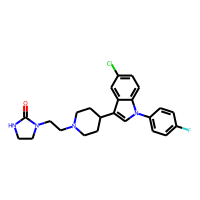
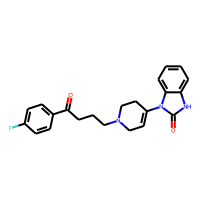
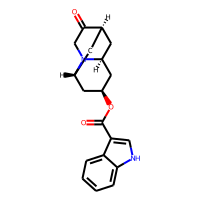
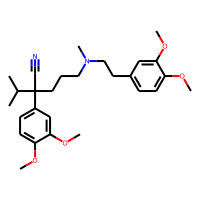
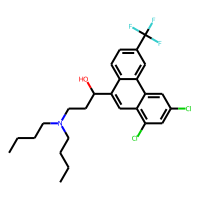
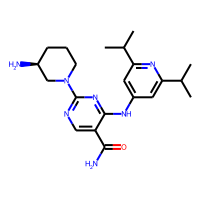
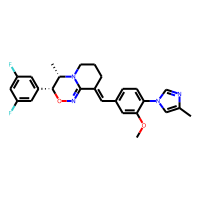
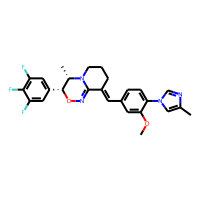
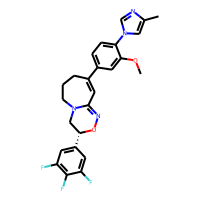
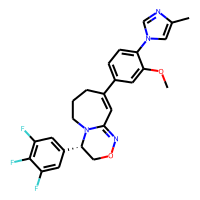

In [4]:
df

In [5]:
df_in_house = pd.read_csv('17_candidates.csv', sep = ",", engine='python')

In [6]:
df_sh = df_in_house.iloc[4: , :]
df_sh.reset_index(drop=True, inplace=True)
df_sh

,Smiles,no,IC50_nM,class
0,CN1CCN(C2=CC(=CC(=C2)S(=O)(=O)C)NC2=NN3C(C4=CC...,26,3240,1
1,CN(CCN(C1C=CC(C2=CC3=C(N2)N=CC=C3NC2=C(P(=O)(C...,48,30000,0
2,CN1CCN(C2=CC(S(=O)(=O)C)=CC(=C2)NC2=NN3C(C4=CC...,336,2116,1
3,CN1CCN(C2CC(NC3=NN4C(C5=CC6=C(C=C5)NN=C6)=CC=C...,341,30000,0
4,CN1CCN(C2=CC(=CC(=C2)S(=O)(=O)C)NC2=NN3C(C4=CC...,410,7577,1
5,CN(CCN1C2=C(C=C(C3N4C(=NC(=N4)NC4=CC(N5CCN(CC5...,415,7111,1
6,CN1CCN(C2=CC(S(=O)(=O)C)=CC(=C2)NC2=NN3C(C4=CC...,417,1966,1
7,CN1CCN(C2=CC(=CC(=C2)NC2=NN3C(C4=CC5=C(C=C4)NN...,422,2616,1
8,CCCN1CCN(C2C=C(S(=O)(=O)C)C=C(C=2)NC2=NN3C(C4=...,429,2811,1
9,CN(CCN1C2=C(C=C(C3N4C(=NC(=N4)NC4=CC(S(=O)(=O)...,432,10252,0


In [7]:
def standardize_smiles(df, col_smiles):
    logs = 0
    mols = []
    for i in df[col_smiles]:    
        mol = Chem.MolFromSmiles(i)
        if mol is not None:
            mols.append(mol)
        else:
            logs+=1
            print(i)
    print(f"Errors: {logs}")
    df["ROMol"] = mols
    return df

Errors: 0
Errors: 0


<ipython-input-7-25d8bc2fafea>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ROMol"] = mols


,Smiles,no,IC50_nM,class,ROMol
0,c1cc(F)ccc1Cn2c(nc(c23)cccc3)NC4CCN(CC4)CCc5cc...,Astemizole,2,1,
1,c1ccc(nc1C)CCN2CCC(CC2)C(=O)c3ccc(cc3)NS(=O)(=O)C,E-4031,35,1,
2,CS(=O)(=O)Nc1ccc(cc1)CCN(C)CCOc2ccc(cc2)NS(=O)...,Dofetilide,11,1,
3,c1cc(F)ccc1C(c2ccc(F)cc2)CCCN3CCC(CC3)n4c(=O)[...,Pimozide,3,1,
4,CN1CCN(C2=CC(=CC(=C2)S(=O)(=O)C)NC2=NN3C(C4=CC...,26,3240,1,
5,CN(CCN(C1C=CC(C2=CC3=C(N2)N=CC=C3NC2=C(P(=O)(C...,48,30000,0,
6,CN1CCN(C2=CC(S(=O)(=O)C)=CC(=C2)NC2=NN3C(C4=CC...,336,2116,1,
7,CN1CCN(C2CC(NC3=NN4C(C5=CC6=C(C=C5)NN=C6)=CC=C...,341,30000,0,
8,CN1CCN(C2=CC(=CC(=C2)S(=O)(=O)C)NC2=NN3C(C4=CC...,410,7577,1,
9,CN(CCN1C2=C(C=C(C3N4C(=NC(=N4)NC4=CC(N5CCN(CC5...,415,7111,1,

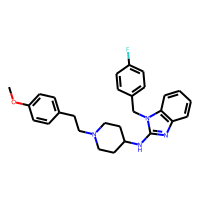
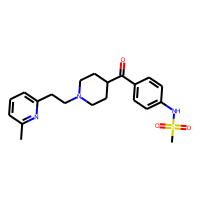
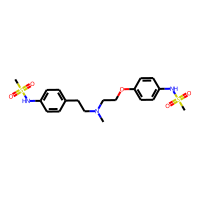
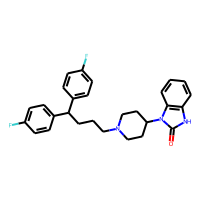
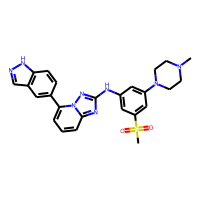
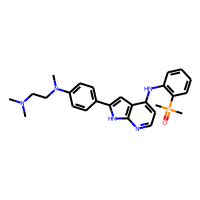
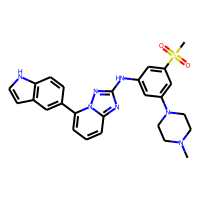
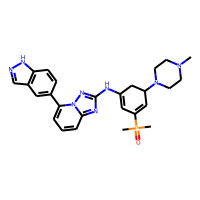
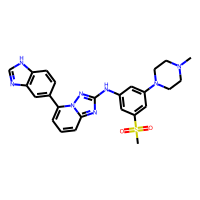
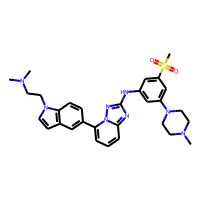
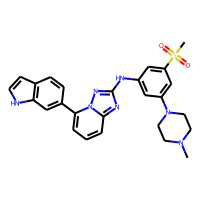
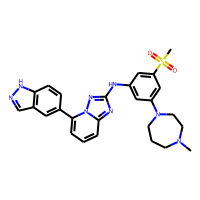
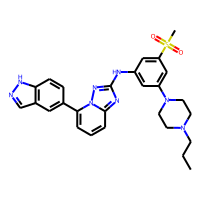
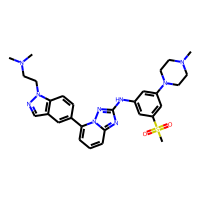
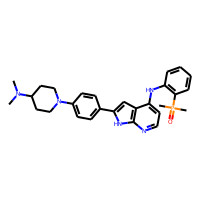
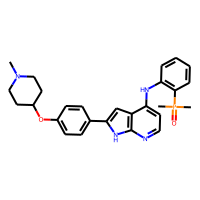
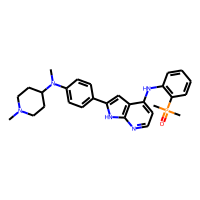

In [8]:
df_in_house = standardize_smiles(df_in_house, "Smiles")
df_sh = standardize_smiles(df_sh, "Smiles")
df_in_house

In [9]:
# создаем словарь из дескриторов структуры (Lipinski module)
ConstDescriptors = {"HeavyAtomCount": Descriptors.HeavyAtomCount,
                    "NHOHCount": Descriptors.NHOHCount,
                    "NOCount": Descriptors.NOCount,
                    "NumHAcceptors": Descriptors.NumHAcceptors,
                    "NumHDonors": Descriptors.NumHDonors,
                    "NumHeteroatoms": Descriptors.NumHeteroatoms,
                    "NumRotatableBonds": Descriptors.NumRotatableBonds,
                    "NumValenceElectrons": Descriptors.NumValenceElectrons,
                    "NumAromaticRings": Descriptors.NumAromaticRings,
                    "NumAliphaticHeterocycles": Descriptors.NumAliphaticHeterocycles,
                    "RingCount": Descriptors.RingCount,
                    "fr_Al_COO": Descriptors.fr_Al_COO,
                    "fr_Al_OH": Descriptors.fr_Al_OH,
                    "fr_amide": Descriptors.fr_amide,
                    "fr_NH0": Descriptors.fr_NH0,
                    "fr_alkyl_halide": Descriptors.fr_alkyl_halide,
                    "fr_hdrzone": Descriptors.fr_hdrzone,
                    "fr_thiazole": Descriptors.fr_thiazole,
                    "CalcFractionCSP3": rdMolDescriptors.CalcFractionCSP3
                   }

# создаем словарь из физико-химических дескрипторов                            
PhisChemDescriptors = {"MW": Descriptors.MolWt,
                       "LogP": Descriptors.MolLogP,
                       "MR": Descriptors.MolMR,
                       "TPSA": Descriptors.TPSA}

# объединяем все дескрипторы в один словарь
descriptors = {}
descriptors.update(ConstDescriptors)
descriptors.update(PhisChemDescriptors)
print(f"Количество дескрипторов в словаре: {len(descriptors)}")


# функция для генерации дескрипторов из молекул
def mol_dsc_calc(mols): 
    return DataFrame({k: f(m) for k, f in descriptors.items()} 
             for m in np.array(mols).ravel())

# оформляем sklearn трансформер для использования в конвеерном моделировании (sklearn Pipeline)
descriptors_transformer = FunctionTransformer(mol_dsc_calc, validate=False)

Количество дескрипторов в словаре: 23


In [10]:
X = descriptors_transformer.transform(df["ROMol"])
df_in_house_fp = descriptors_transformer.transform(df_in_house["ROMol"])
df_sh_fp = descriptors_transformer.transform(df_sh["ROMol"])

In [11]:
scaler = StandardScaler()
scaler.fit(X.values)
X_norm_SS = DataFrame(scaler.transform(X.values), index=X.index, columns=X.columns)
scaler.fit(df_in_house_fp.values)
df_norm = DataFrame(scaler.transform(df_in_house_fp.values), index=df_in_house_fp.index, columns=df_in_house_fp.columns)
scaler.fit(df_sh_fp.values)
df_sh_norm = DataFrame(scaler.transform(df_sh_fp.values), index=df_sh_fp.index, columns=df_sh_fp.columns)

In [12]:
X_norm_SS["pIC50"] = df["pIC50"]
X_norm_SS["value_nM"] = df["value_nM"]
X_norm_SS

,HeavyAtomCount,NHOHCount,NOCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumAliphaticHeterocycles,...,fr_alkyl_halide,fr_hdrzone,fr_thiazole,CalcFractionCSP3,MW,LogP,MR,TPSA,pIC50,value_nM
0,-0.038578,-0.457167,-0.648402,-1.219804,-0.347769,-0.379486,-0.275674,-0.057178,0.190996,0.925906,...,-0.459505,-0.090701,-0.232457,-0.021651,0.014877,0.597462,0.144080,-1.189182,7.853872,14.0
1,-0.524506,-0.457167,-0.648402,-0.758397,-0.347769,-0.748391,0.142735,-0.604160,0.190996,-0.175996,...,-0.459505,-0.090701,-0.232457,-0.687984,-0.691174,-0.086643,-0.469958,-0.638352,7.492144,32.2
2,-1.172410,-0.457167,-0.648402,-0.758397,-0.347769,-1.117296,-1.530900,-1.211918,-0.782843,3.129712,...,-0.459505,-0.090701,-0.232457,0.621303,-1.323078,-0.922243,-1.321449,-0.503697,5.225483,5950.0
3,0.285374,-1.236432,-0.219707,0.164416,-1.287829,-0.748391,3.071596,0.489805,-0.782843,-1.277899,...,-0.459505,-0.090701,-0.232457,0.913410,0.171673,0.932942,0.590966,-0.455159,6.844664,143.0
4,0.285374,-0.457167,-1.934486,-1.681211,-0.347769,-0.379486,1.816370,0.489805,0.190996,-1.277899,...,1.807817,-0.090701,-0.232457,0.542170,0.697593,3.492370,0.620062,-1.722789,6.707744,196.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8153,-0.362530,2.659896,0.637682,0.625823,1.532350,-0.010581,0.142735,-0.239505,-0.782843,-0.175996,...,-0.459505,-0.090701,-0.232457,0.947882,-0.483519,-0.656010,-0.121552,1.395556,5.431798,3700.0
8154,0.447350,-1.236432,-0.219707,0.164416,-1.287829,-0.010581,-0.694082,0.368253,0.190996,0.925906,...,-0.459505,-0.090701,-0.232457,-0.460178,0.285360,1.168718,0.332229,-0.833131,5.697453,2007.0
8155,0.609326,-1.236432,-0.219707,0.164416,-1.287829,0.358323,-0.694082,0.550581,0.190996,0.925906,...,-0.459505,-0.090701,-0.232457,-0.460178,0.491844,1.268969,0.330357,-0.833131,5.793984,1607.0
8156,0.447350,-1.236432,-0.219707,0.164416,-1.287829,0.358323,-0.694082,0.368253,0.190996,0.925906,...,-0.459505,-0.090701,-0.232457,-0.640600,0.330846,0.988971,0.125552,-0.833131,5.474696,3352.0


In [13]:
X_norm_SS["pIC50"] = pd.to_numeric(X_norm_SS["pIC50"])
X_norm_SS["value_nM"] = pd.to_numeric(X_norm_SS["value_nM"])

In [14]:
X_norm_SS.to_csv("descriptors_struct_phys.csv", encoding='utf-8', index=False)

In [15]:

corr_df_pearson = X_norm_SS.corr(method="pearson")
corr_df_pearson[np.abs(corr_df_pearson['pIC50']) > 0.1]['pIC50']

NHOHCount           -0.135866
NOCount             -0.195831
NumHAcceptors       -0.156287
NumHDonors          -0.142673
NumHeteroatoms      -0.182240
NumRotatableBonds    0.119367
fr_amide            -0.137049
LogP                 0.269803
TPSA                -0.232164
pIC50                1.000000
value_nM            -0.114401
Name: pIC50, dtype: float64

In [16]:
# ! conda install seaborn -y

<AxesSubplot:>

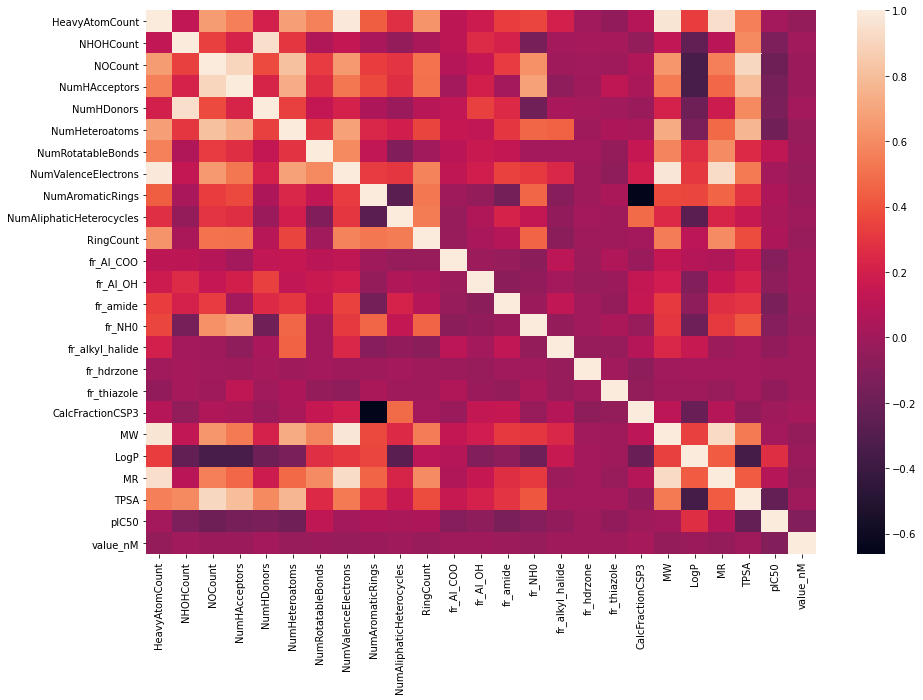

In [17]:

plt.figure(figsize=(15, 10))
sns.heatmap(corr_df_pearson)

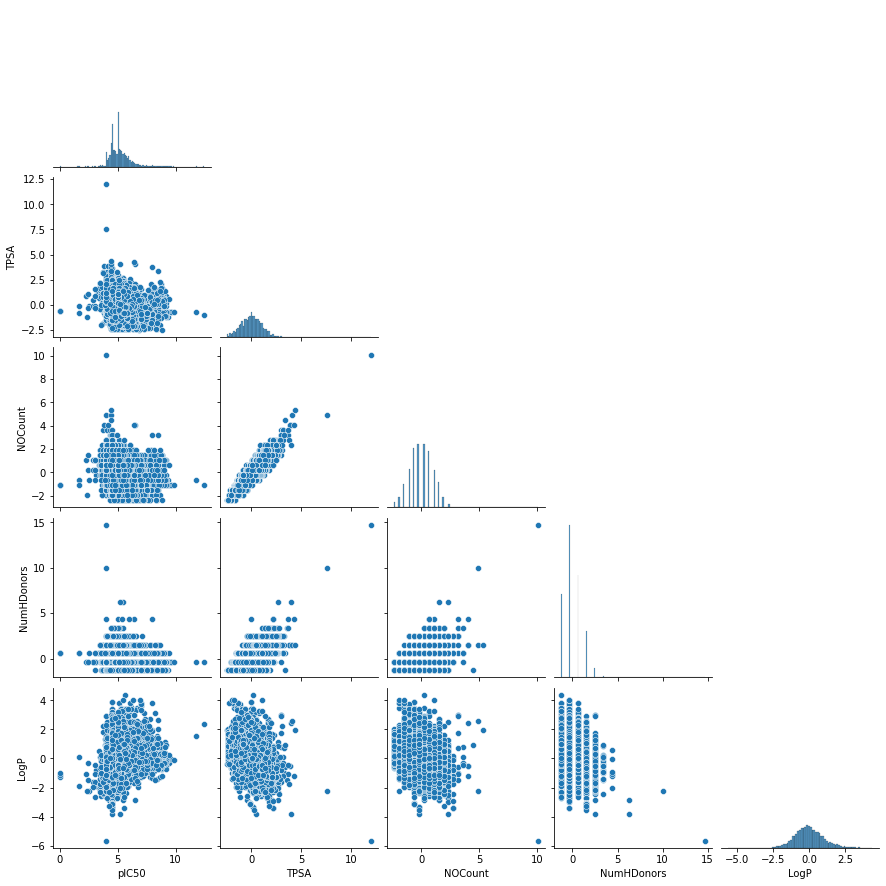

In [18]:
sns.pairplot(X_norm_SS[["pIC50", "TPSA", "NOCount", "NumHDonors","LogP"]], corner=True)

значимой корреляции pIC50 с  LogP не видно

Попробуем комбинации:

In [19]:
X_norm_SS["LogP_NumRotatableBonds_NumAromaticRings"] = X_norm_SS[["LogP","NumRotatableBonds","NumAromaticRings"]].sum(axis=1)
X_norm_SS["TPSA_NOCount"] = X_norm_SS[["TPSA","NOCount"]].sum(axis=1)

In [20]:
df_test = X_norm_SS[["pIC50",
                  "LogP_NumRotatableBonds_NumAromaticRings",
                  "TPSA_NOCount"
                 ]]

In [21]:
corr_df_test_pearson = df_test.corr(method="pearson")
corr_df_test_pearson[np.abs(corr_df_test_pearson["pIC50"]) > 0.1]["pIC50"]

pIC50                                      1.000000
LogP_NumRotatableBonds_NumAromaticRings    0.207028
TPSA_NOCount                              -0.218715
Name: pIC50, dtype: float64

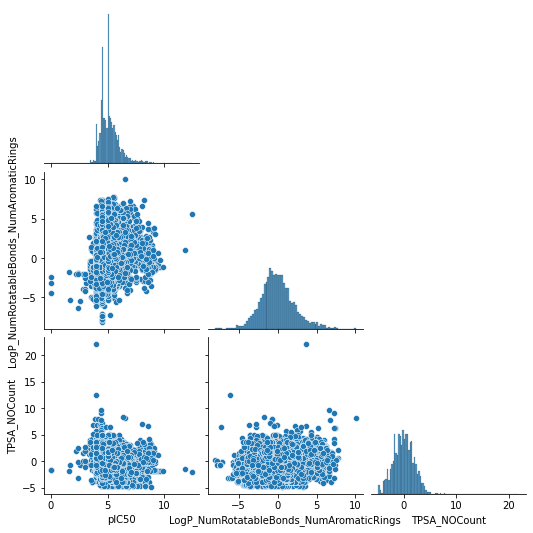

In [22]:
sns.pairplot(X_norm_SS[["pIC50", "LogP_NumRotatableBonds_NumAromaticRings", "TPSA_NOCount"]], corner=True)

Улучшения при линейной комбинациии признаков не наблюдается

# Дескрипторы Шредингера ( QikProp)

In [23]:
def read_csv_with_nan(csv_file):
    from csv import reader
    # open file in read mode
    with open(csv_file, 'r') as read_obj:
        # pass the file object to reader() to get the reader object
        csv_reader = reader(read_obj)
        # Iterate over each row in the csv using reader object
        a = []
        for row in csv_reader:
            a.append(row)
            # row variable is a list that represents a row in csv
            # print(row)
    d_schroedinger = pd.DataFrame(a)
    d_schroedinger.columns = d_schroedinger.iloc[0]
    d_schroedinger = d_schroedinger[1:]
    d_schroedinger = d_schroedinger.loc[:, d_schroedinger.columns.notnull()]
    return d_schroedinger

In [24]:
d_schroedinger = read_csv_with_nan("qikprop_8k.csv")
d_schroedinger

,molecule,#stars,#amine,#amidine,#acid,#amide,#rotor,#rtvFG,CNS,mol_MW,...,PSA,#NandO,RuleOfFive,#ringatoms,#in34,#in56,#noncon,#nonHatm,RuleOfThree,Jm
1,CHEMBL12713,1,1,0,0,0,3,0,1,440.947,...,53.329,5,1,26,0,26,7,31,1,0.000
2,CHEMBL1108,0,1,0,0,0,5,0,1,379.433,...,77.075,5,0,21,0,21,3,28,0,0.000
3,CHEMBL2368925,0,1,0,0,0,2,1,1,324.379,...,75.722,5,0,20,0,20,9,24,0,0.004
4,CHEMBL6966,0,1,0,0,0,14,0,1,454.608,...,51.629,6,0,12,0,12,0,33,0,0.747
5,CHEMBL1107,3,1,0,0,0,11,0,2,500.430,...,20.369,2,2,14,0,14,0,33,1,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8154,CHEMBL4635883,0,1,0,0,0,6,0,-1,397.522,...,114.703,8,0,18,0,18,5,29,0,0.000
8155,CHEMBL4643105,1,0,0,0,0,3,0,1,464.514,...,46.398,6,1,27,0,27,5,34,1,0.000
8156,CHEMBL4634921,2,0,0,0,0,3,0,1,482.504,...,46.395,6,1,27,0,27,5,35,1,0.000
8157,CHEMBL4634696,1,0,0,0,0,1,0,1,468.478,...,49.142,6,1,28,0,23,5,34,1,0.000


In [95]:
d_sch_17 = read_csv_with_nan("qikprop_17.csv")
d_sch_17.reset_index(drop=True, inplace=True)

In [97]:
d_sch_13 = d_sch_17.iloc[4: , :]

In [99]:
d_sch_13.reset_index(drop=True, inplace=True)

In [28]:
d_schroedinger.reset_index(drop=True, inplace=True)

In [29]:
d_schroedinger

,molecule,#stars,#amine,#amidine,#acid,#amide,#rotor,#rtvFG,CNS,mol_MW,...,PSA,#NandO,RuleOfFive,#ringatoms,#in34,#in56,#noncon,#nonHatm,RuleOfThree,Jm
0,CHEMBL12713,1,1,0,0,0,3,0,1,440.947,...,53.329,5,1,26,0,26,7,31,1,0.000
1,CHEMBL1108,0,1,0,0,0,5,0,1,379.433,...,77.075,5,0,21,0,21,3,28,0,0.000
2,CHEMBL2368925,0,1,0,0,0,2,1,1,324.379,...,75.722,5,0,20,0,20,9,24,0,0.004
3,CHEMBL6966,0,1,0,0,0,14,0,1,454.608,...,51.629,6,0,12,0,12,0,33,0,0.747
4,CHEMBL1107,3,1,0,0,0,11,0,2,500.430,...,20.369,2,2,14,0,14,0,33,1,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8153,CHEMBL4635883,0,1,0,0,0,6,0,-1,397.522,...,114.703,8,0,18,0,18,5,29,0,0.000
8154,CHEMBL4643105,1,0,0,0,0,3,0,1,464.514,...,46.398,6,1,27,0,27,5,34,1,0.000
8155,CHEMBL4634921,2,0,0,0,0,3,0,1,482.504,...,46.395,6,1,27,0,27,5,35,1,0.000
8156,CHEMBL4634696,1,0,0,0,0,1,0,1,468.478,...,49.142,6,1,28,0,23,5,34,1,0.000


In [30]:
df_all = pd.concat([X_norm_SS,d_schroedinger],axis=1)

In [81]:
df_17 = pd.concat([df_norm,d_sch_17],axis=1)

In [100]:
df_13 = pd.concat([df_sh_norm,d_sch_13],axis=1)

In [31]:
df_all = pd.concat([df_all,df["class"]],axis=1)


In [32]:
df_all = pd.concat([df_all,df["pIC50"]],axis=1)
df_all

,HeavyAtomCount,NHOHCount,NOCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumAliphaticHeterocycles,...,RuleOfFive,#ringatoms,#in34,#in56,#noncon,#nonHatm,RuleOfThree,Jm,class,pIC50
0,-0.038578,-0.457167,-0.648402,-1.219804,-0.347769,-0.379486,-0.275674,-0.057178,0.190996,0.925906,...,1,26,0,26,7,31,1,0.000,1,7.853872
1,-0.524506,-0.457167,-0.648402,-0.758397,-0.347769,-0.748391,0.142735,-0.604160,0.190996,-0.175996,...,0,21,0,21,3,28,0,0.000,1,7.492144
2,-1.172410,-0.457167,-0.648402,-0.758397,-0.347769,-1.117296,-1.530900,-1.211918,-0.782843,3.129712,...,0,20,0,20,9,24,0,0.004,1,5.225483
3,0.285374,-1.236432,-0.219707,0.164416,-1.287829,-0.748391,3.071596,0.489805,-0.782843,-1.277899,...,0,12,0,12,0,33,0,0.747,1,6.844664
4,0.285374,-0.457167,-1.934486,-1.681211,-0.347769,-0.379486,1.816370,0.489805,0.190996,-1.277899,...,2,14,0,14,0,33,1,0.000,1,6.707744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8153,-0.362530,2.659896,0.637682,0.625823,1.532350,-0.010581,0.142735,-0.239505,-0.782843,-0.175996,...,0,18,0,18,5,29,0,0.000,1,5.431798
8154,0.447350,-1.236432,-0.219707,0.164416,-1.287829,-0.010581,-0.694082,0.368253,0.190996,0.925906,...,1,27,0,27,5,34,1,0.000,1,5.697453
8155,0.609326,-1.236432,-0.219707,0.164416,-1.287829,0.358323,-0.694082,0.550581,0.190996,0.925906,...,1,27,0,27,5,35,1,0.000,1,5.793984
8156,0.447350,-1.236432,-0.219707,0.164416,-1.287829,0.358323,-0.694082,0.368253,0.190996,0.925906,...,1,28,0,23,5,34,1,0.000,1,5.474696


In [34]:
df_all.isna().sum().sum()

0

In [35]:
def count_nan_index(df_all):
    k = 0
    l = 0
    index_nan = []
    for i in df_all["#stars"]:
        k += 1
        if i == "":
            index_nan.append(df_all.index[k-1])
            l += 1
    print(l)
    print(index_nan)
    return index_nan

In [36]:
index_nan = count_nan_index(df_all)

47
[93, 337, 2575, 2723, 3733, 3734, 3735, 3736, 3738, 3740, 3742, 3743, 3744, 3745, 3746, 3747, 3748, 3749, 3750, 3751, 3752, 3753, 3754, 3755, 3756, 3757, 3758, 3759, 3760, 3761, 3762, 3763, 3764, 3765, 3766, 4249, 4255, 4274, 5067, 6558, 6559, 6560, 6561, 6678, 6971, 7558, 7559]


In [37]:
df_all.drop(df_all.index[index_nan], inplace=True)

In [38]:
df_all

,HeavyAtomCount,NHOHCount,NOCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumAliphaticHeterocycles,...,RuleOfFive,#ringatoms,#in34,#in56,#noncon,#nonHatm,RuleOfThree,Jm,class,pIC50
0,-0.038578,-0.457167,-0.648402,-1.219804,-0.347769,-0.379486,-0.275674,-0.057178,0.190996,0.925906,...,1,26,0,26,7,31,1,0.000,1,7.853872
1,-0.524506,-0.457167,-0.648402,-0.758397,-0.347769,-0.748391,0.142735,-0.604160,0.190996,-0.175996,...,0,21,0,21,3,28,0,0.000,1,7.492144
2,-1.172410,-0.457167,-0.648402,-0.758397,-0.347769,-1.117296,-1.530900,-1.211918,-0.782843,3.129712,...,0,20,0,20,9,24,0,0.004,1,5.225483
3,0.285374,-1.236432,-0.219707,0.164416,-1.287829,-0.748391,3.071596,0.489805,-0.782843,-1.277899,...,0,12,0,12,0,33,0,0.747,1,6.844664
4,0.285374,-0.457167,-1.934486,-1.681211,-0.347769,-0.379486,1.816370,0.489805,0.190996,-1.277899,...,2,14,0,14,0,33,1,0.000,1,6.707744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8153,-0.362530,2.659896,0.637682,0.625823,1.532350,-0.010581,0.142735,-0.239505,-0.782843,-0.175996,...,0,18,0,18,5,29,0,0.000,1,5.431798
8154,0.447350,-1.236432,-0.219707,0.164416,-1.287829,-0.010581,-0.694082,0.368253,0.190996,0.925906,...,1,27,0,27,5,34,1,0.000,1,5.697453
8155,0.609326,-1.236432,-0.219707,0.164416,-1.287829,0.358323,-0.694082,0.550581,0.190996,0.925906,...,1,27,0,27,5,35,1,0.000,1,5.793984
8156,0.447350,-1.236432,-0.219707,0.164416,-1.287829,0.358323,-0.694082,0.368253,0.190996,0.925906,...,1,28,0,23,5,34,1,0.000,1,5.474696


Сохраним дескрипторы

In [39]:
df_all.to_csv("d_schroed_phys_chem_8111.csv", encoding='utf-8', index=False)

In [49]:
# df_all.dtypes

In [50]:
corr_df_pearson = df_all.corr(method="pearson")
corr_df_pearson[np.abs(corr_df_pearson['pIC50']) > 0.1]['pIC50']

NHOHCount                                 -0.130849
NOCount                                   -0.188706
NumHAcceptors                             -0.147001
NumHDonors                                -0.137318
NumHeteroatoms                            -0.175068
NumRotatableBonds                          0.112685
fr_amide                                  -0.133279
LogP                                       0.268556
TPSA                                      -0.225444
pIC50                                      1.000000
value_nM                                  -0.115144
LogP_NumRotatableBonds_NumAromaticRings    0.203848
TPSA_NOCount                              -0.211704
Name: pIC50, dtype: float64

<AxesSubplot:>

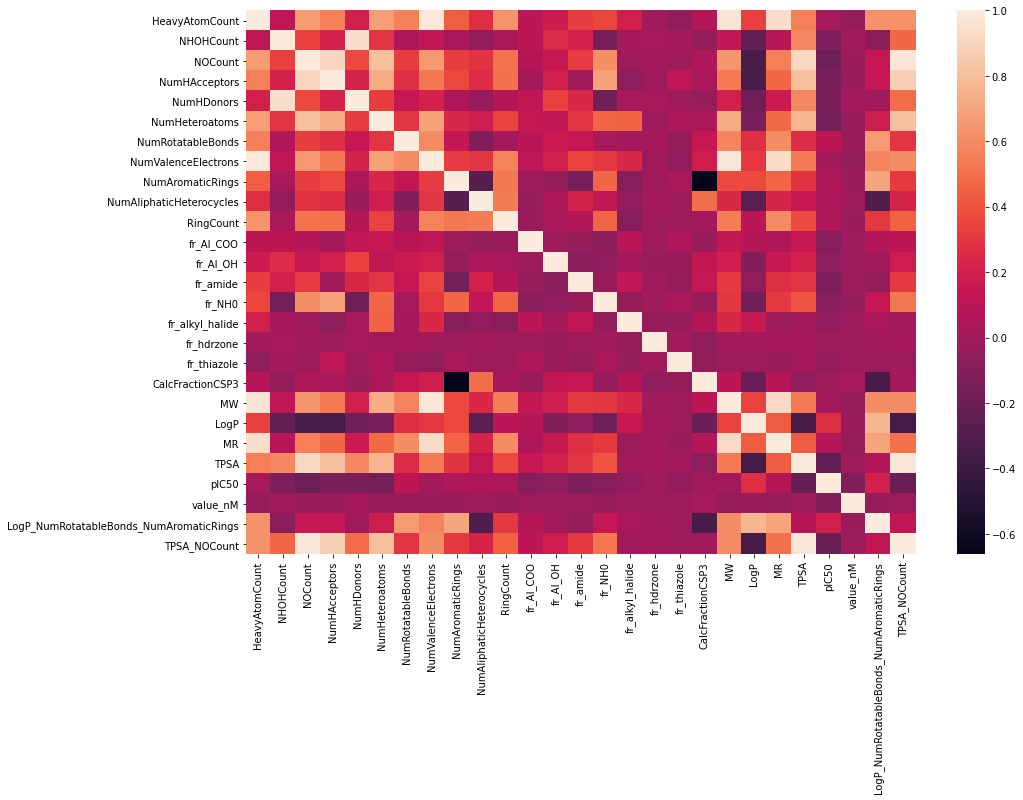

In [51]:
plt.figure(figsize=(15, 10))
sns.heatmap(corr_df_pearson)

In [52]:
df_x = df_all.drop(["class", 'pIC50', "molecule", "value_nM", 'QPlogHERG'], axis =1)

In [54]:
pd.set_option('display.max_rows', 60)
pd.set_option('display.max_columns', None)

In [55]:
df_x.astype(float)

,HeavyAtomCount,NHOHCount,NOCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumAliphaticHeterocycles,RingCount,fr_Al_COO,fr_Al_OH,fr_amide,fr_NH0,fr_alkyl_halide,fr_hdrzone,fr_thiazole,CalcFractionCSP3,MW,LogP,MR,TPSA,LogP_NumRotatableBonds_NumAromaticRings,TPSA_NOCount,#stars,#amine,#amidine,#acid,#amide,#rotor,#rtvFG,CNS,mol_MW,dipole,SASA,FOSA,FISA,PISA,WPSA,volume,donorHB,accptHB,dip^2/V,ACxDN^.5/SA,glob,QPpolrz,QPlogPC16,QPlogPoct,QPlogPw,QPlogPo/w,QPlogS,CIQPlogS,QPPCaco,QPlogBB,QPPMDCK,QPlogKp,IP(eV),EA(eV),#metab,QPlogKhsa,HumanOralAbsorption,PercentHumanOralAbsorption,SAfluorine,SAamideO,PSA,#NandO,RuleOfFive,#ringatoms,#in34,#in56,#noncon,#nonHatm,RuleOfThree,Jm
0,-0.038578,-0.457167,-0.648402,-1.219804,-0.347769,-0.379486,-0.275674,-0.057178,0.190996,0.925906,0.602838,-0.178048,-0.379216,1.541562,0.012304,-0.459505,-0.090701,-0.232457,-0.021651,0.014877,0.597462,0.144080,-1.189182,0.512784,-1.837584,1.0,1.0,0.0,0.0,0.0,3.0,0.0,1.0,440.947,7.294,761.664,293.212,83.169,266.744,118.538,1357.996,1.0,4.00,0.039181,0.005252,0.778635,48.814,13.861,20.711,8.717,5.802,-7.488,-6.655,401.892,0.158,911.323,-3.887,8.287,0.737,2.0,1.406,1.0,94.566,47.013,0.0,53.329,5.0,1.0,26.0,0.0,26.0,7.0,31.0,1.0,0.000
1,-0.524506,-0.457167,-0.648402,-0.758397,-0.347769,-0.748391,0.142735,-0.604160,0.190996,-0.175996,-0.224543,-0.178048,-0.379216,-0.920712,-0.571299,-0.459505,-0.090701,-0.232457,-0.687984,-0.691174,-0.086643,-0.469958,-0.638352,0.247087,-1.286754,0.0,1.0,0.0,0.0,0.0,5.0,0.0,1.0,379.433,5.335,688.755,177.594,125.727,338.396,47.039,1213.372,1.0,6.00,0.023458,0.008711,0.798785,42.426,12.714,19.294,10.822,3.501,-4.768,-4.546,158.684,-0.538,135.450,-4.227,8.729,0.849,4.0,0.516,3.0,86.833,47.039,0.0,77.075,5.0,0.0,21.0,0.0,21.0,3.0,28.0,0.0,0.000
2,-1.172410,-0.457167,-0.648402,-0.758397,-0.347769,-1.117296,-1.530900,-1.211918,-0.782843,3.129712,1.430220,-0.178048,-0.379216,-0.920712,-1.154902,-0.459505,-0.090701,-0.232457,0.621303,-1.323078,-0.922243,-1.321449,-0.503697,-3.235987,-1.152099,0.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,324.379,4.883,586.577,257.421,112.191,216.965,0.000,1029.591,0.0,5.00,0.023158,0.000000,0.840652,35.838,10.085,14.703,7.854,2.528,-3.170,-3.210,213.250,-0.217,103.000,-4.693,8.605,0.334,2.0,0.184,3.0,83.429,0.000,0.0,75.722,5.0,0.0,20.0,0.0,20.0,9.0,24.0,0.0,0.004
3,0.285374,-1.236432,-0.219707,0.164416,-1.287829,-0.748391,3.071596,0.489805,-0.782843,-1.277899,-1.879306,-0.178048,-0.379216,-0.920712,-0.571299,-0.459505,-0.090701,-0.232457,0.913410,0.171673,0.932942,0.590966,-0.455159,3.221694,-0.674866,0.0,1.0,0.0,0.0,0.0,14.0,0.0,1.0,454.608,6.826,678.150,557.072,36.750,84.328,0.000,1416.270,0.0,6.50,0.032899,0.000000,0.899366,42.341,12.123,17.312,5.489,4.027,-4.280,-6.384,1107.391,-0.185,611.102,-2.618,8.388,-0.121,6.0,0.396,3.0,100.000,0.000,0.0,51.629,6.0,0.0,12.0,0.0,12.0,0.0,33.0,0.0,0.747
4,0.285374,-0.457167,-1.934486,-1.681211,-0.347769,-0.379486,1.816370,0.489805,0.190996,-1.277899,-1.051925,-0.178048,1.869072,-0.920712,-1.154902,1.807817,-0.090701,-0.232457,0.542170,0.697593,3.492370,0.620062,-1.722789,5.499735,-3.657276,3.0,1.0,0.0,0.0,0.0,11.0,0.0,2.0,500.430,1.992,801.252,373.323,13.430,164.009,250.490,1471.548,1.0,3.70,0.002695,0.004618,0.780870,47.241,13.670,19.421,5.625,7.526,-7.605,-7.751,1842.638,0.767,10000.000,-2.196,8.868,1.494,2.0,1.449,1.0,100.000,117.620,0.0,20.369,2.0,2.0,14.0,0.0,14.0,0.0,33.0,1.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8153,-0.362530,2.659896,0.637682,0.625823,1.532350,-0.010581,0.142735,-0.239505,-0.782843,-0.175996,-1.051925,-0.178048,-0.379216,0.310425,0.595908,-0.459505,-0.090701,-0.232457,0.947882,-0.483519,-0.656010,-0.121552,1.395556,-1.296119,2.0

Анализ feature importance объединенных дескрипторов Шредингера и структрных+физико-химических

In [56]:
Yc = df_all["class"]
X = df_x

X_train, X_test, y_train, y_test = train_test_split(X, Yc, shuffle=True, random_state=75, train_size=.8)

In [57]:


feature_names = [f'feature {i}' for i in df_x.columns]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [58]:

start_time = time.time()
importances = forest.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.020 seconds


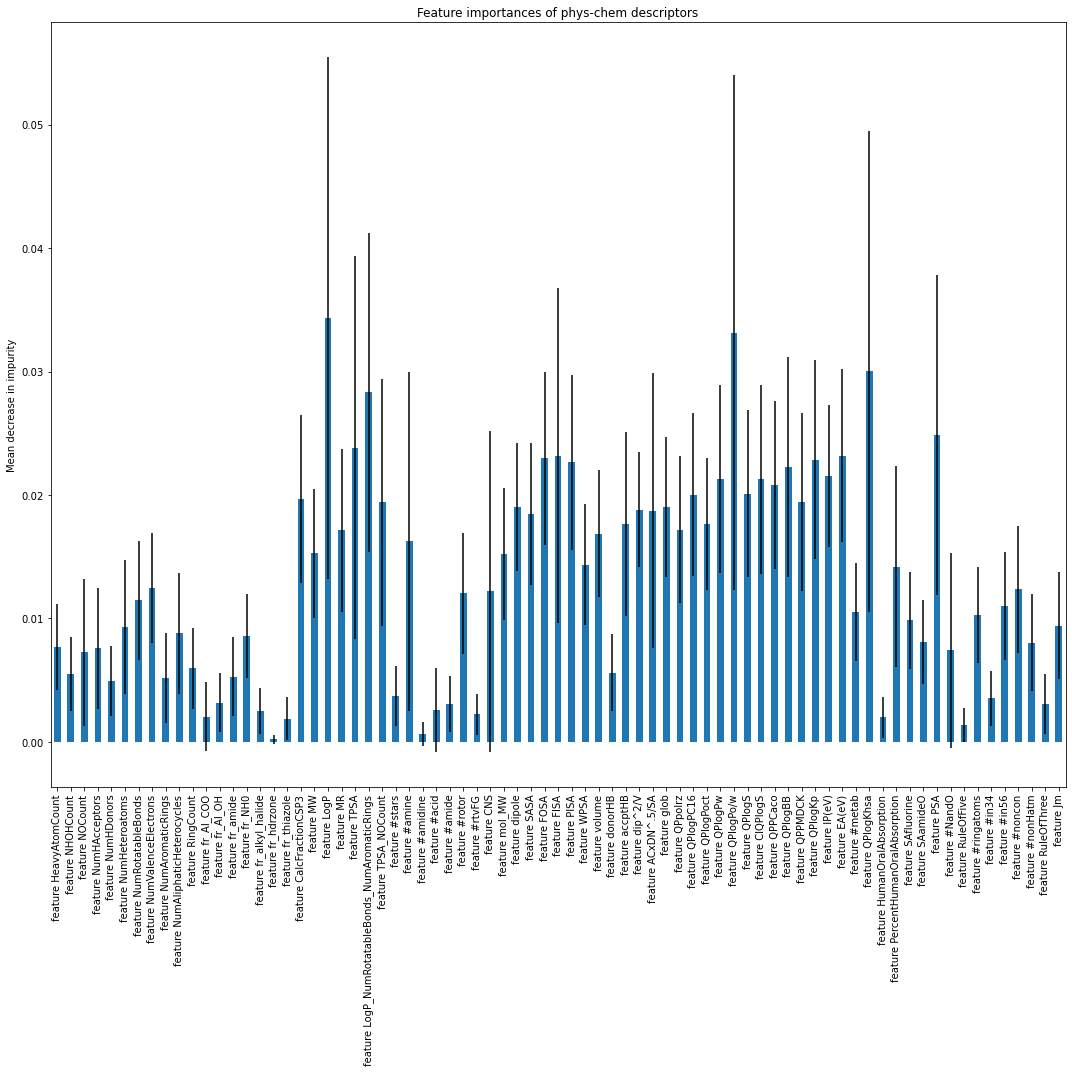

In [59]:

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(15, 15))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances of phys-chem descriptors")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Но больше нас интереесует feature importance с permutation:

In [60]:

start_time = time.time()
result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 22.714 seconds


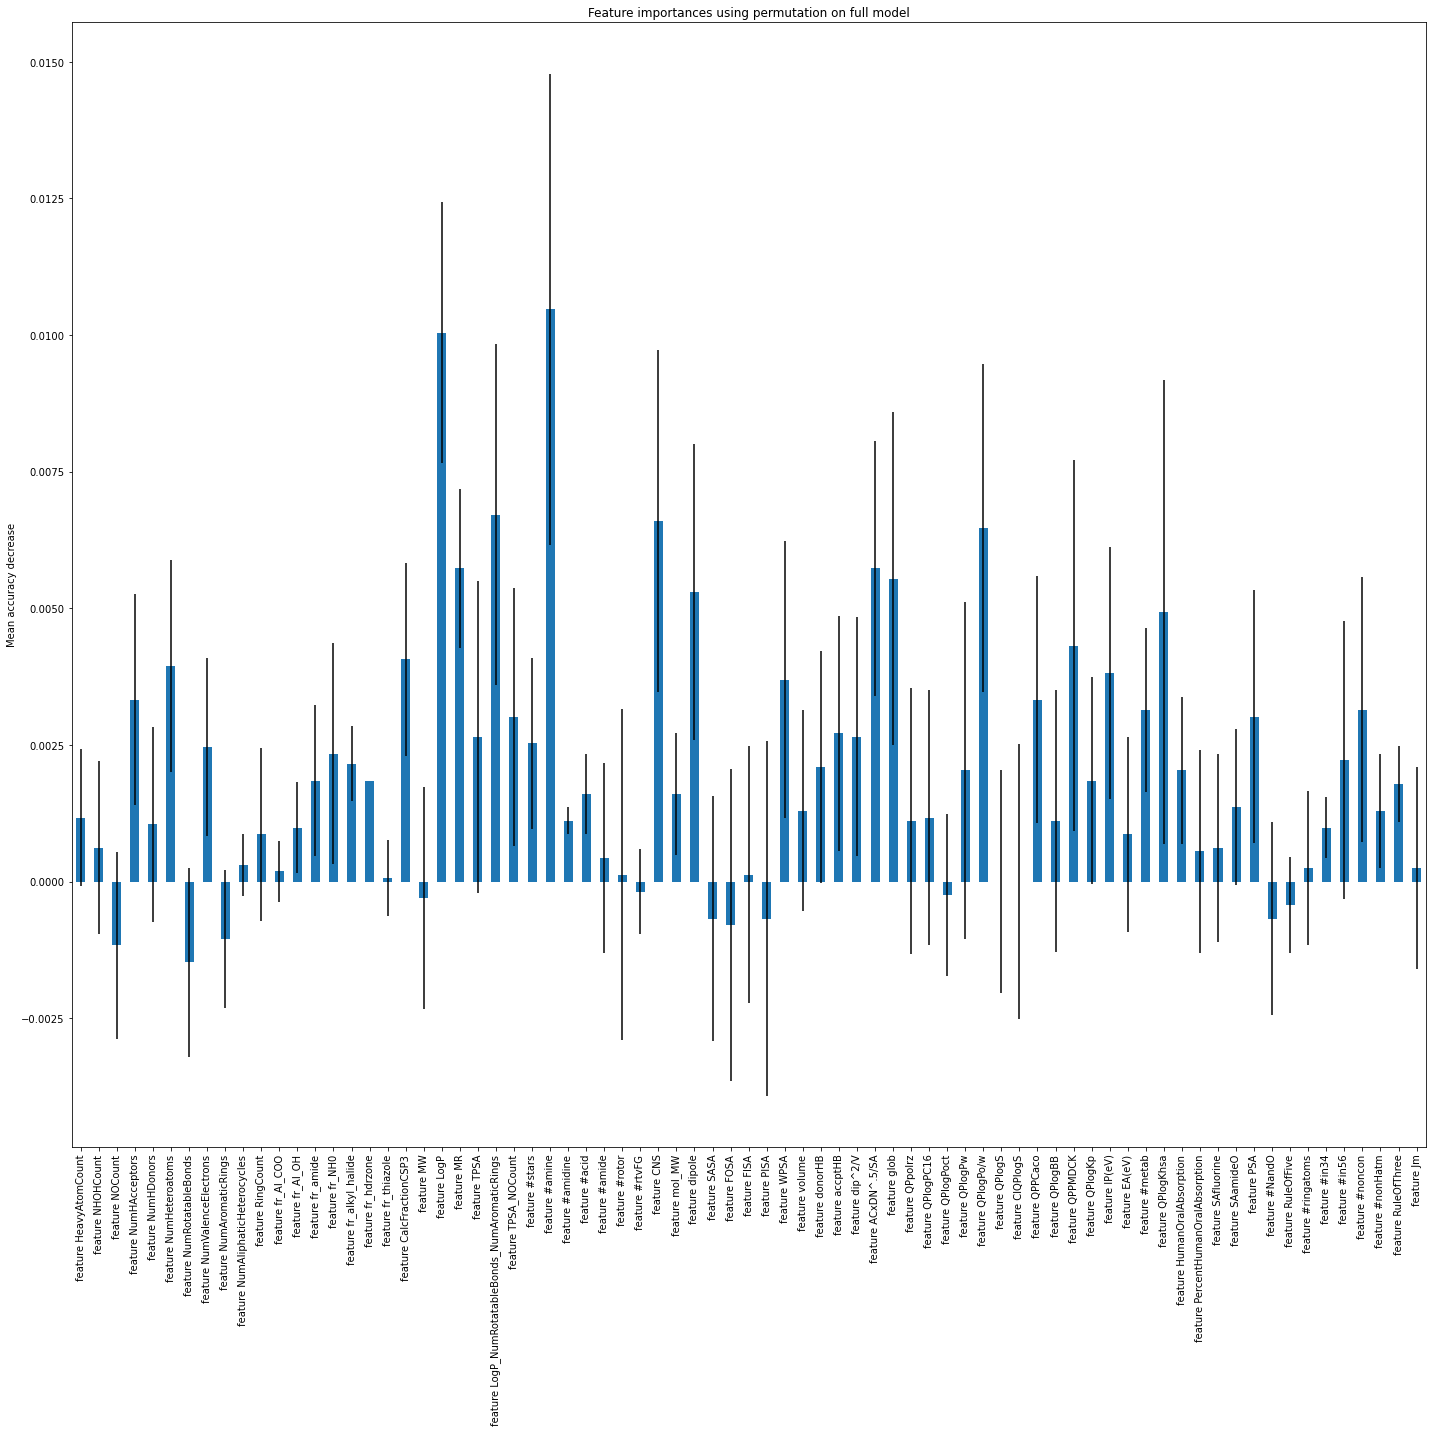

In [61]:
fig, ax = plt.subplots(figsize=(20,20))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [141]:
# d_schroedinger.dtypes

In [62]:
df_x1 = df_x[["LogP", "MR", "#amine", "CNS", 'dipole', 'ACxDN^.5/SA', 'glob', 'QPlogPo/w']]

In [83]:
df_17_1 = df_17[["LogP", "MR", "#amine", "CNS", 'dipole', 'ACxDN^.5/SA', 'glob', 'QPlogPo/w']]

In [101]:
df_13_1 = df_13[["LogP", "MR", "#amine", "CNS", 'dipole', 'ACxDN^.5/SA', 'glob', 'QPlogPo/w']]

In [63]:
Yc = df_all["class"]
X = df_x1
X_train, X_test, y_train, y_test = train_test_split(X, Yc, shuffle=True, random_state=75, train_size=.8)

In [64]:

clf = RandomForestClassifier(n_estimators = 1000, criterion = 'entropy', random_state=42)
print (np.mean(cross_val_score(clf, df_x1, Yc, scoring='roc_auc', cv=10)))

0.6538961854583208


In [70]:
clf1 = RandomForestClassifier(random_state=42, n_estimators = 1000, criterion = 'entropy')
clf2 = CatBoostClassifier(learning_rate=0.1, loss_function='Logloss', verbose = False)

In [71]:
eclf = VotingClassifier(estimators=[('RF1', clf1), ('CatBoost', clf2)], voting ='soft', weights=[1, 1])

In [88]:
eclf = eclf.fit(X_train, y_train.astype(int))

In [89]:
def print_metrics(y_test, X_test, clf):
    y_testf1 = np.transpose((np.array(y_test)).astype(np.int64))
    zt = clf.predict(X_test).astype(np.int64)
    print(f"roc auc test_set = {roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])}")
    print(f"bac test_set = {balanced_accuracy_score(y_test, clf.predict(X_test))}")
    print(f"acc test_set = {accuracy_score(y_test, clf.predict(X_test))}")
    print(f"f1_score ={f1_score(y_testf1, zt)}")
    print(f"recall_score ={recall_score(y_testf1, zt)}")
    print(f"precision_score ={precision_score(y_testf1, zt)}")

In [91]:
res = print_metrics(y_test.astype(int), X_test, eclf)

roc auc test_set = 0.7668601209546999
bac test_set = 0.6940782849087348
acc test_set = 0.6968576709796673
f1_score =0.6675675675675676
recall_score =0.6534391534391535
precision_score =0.6823204419889503


In [92]:
res = print_metrics(df_in_house["class"], df_17_1, eclf)

roc auc test_set = 0.36363636363636365
bac test_set = 0.25757575757575757
acc test_set = 0.23529411764705882
f1_score =0.23529411764705885
recall_score =0.18181818181818182
precision_score =0.3333333333333333


In [102]:
res = print_metrics(df_sh["class"], df_13_1, eclf)

roc auc test_set = 0.23809523809523808
bac test_set = 0.369047619047619
acc test_set = 0.38461538461538464
f1_score =0.5
recall_score =0.5714285714285714
precision_score =0.4444444444444444


In [104]:
y_test = y_test.astype("int64")
y_test1 = df_sh["class"].astype("int64")
y_test2 = df_in_house["class"].astype("int64")
probs = eclf.predict_proba(X_test)
probs1 = eclf.predict_proba(df_13_1)
probs2 = eclf.predict_proba(df_17_1)
preds = probs[:,1]
preds1 = probs1[:,1]
preds2 = probs2[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds,pos_label = 1)
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test1, preds1, pos_label = 1)
fpr2, tpr2, threshold2 = metrics.roc_curve(y_test2, preds2, pos_label = 1)
roc_auc = metrics.auc(fpr, tpr)
roc_auc1 = metrics.auc(fpr1, tpr1)
roc_auc2 = metrics.auc(fpr2, tpr2)

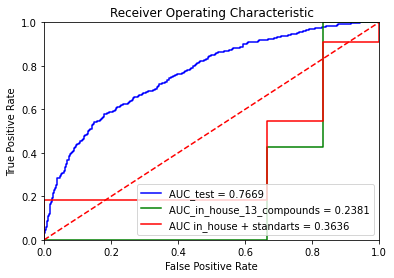

In [105]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = f'AUC_test = {roc_auc.round(4)}')
plt.plot(fpr1, tpr1, 'g', label = f'AUC_in_house_13_compounds = {roc_auc1.round(4)}')
plt.plot(fpr2, tpr2, 'r', label = f'AUC in_house + standarts = {roc_auc2.round(4)}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Вывод
- В данном случае через feature importance (c permutation) было отобрано меньше дескрипторов (8: "LogP", "MR", "#amine", "CNS", 'dipole', 'ACxDN^.5/SA', 'glob', 'QPlogPo/w'), которые. в то же время имеют корреляцию с pIC50.
- В данном случае нормализация данных не приводит к тому, что в датасете с in-house данными со стандартами полностью теряется способность их отличать (как в случае с дескрипторами Моргана). Сейчас значения roc_auc для сета со стандартами стали 0.3636 в отличие от построения на дескрипторах Морагана (0.52).
- Проблема с переобучением модели по-прежнему остается. 
